In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


The pretrained model will be VGG16, we used this because the author of the below link (https://www.kaggle.com/danaelisanicolas/cnn-part-4-training-and-modelling-with-vgg16) used it to classify resipiratory sounds.

In [3]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import metrics

from sklearn.utils import class_weight
from collections import Counter

import matplotlib.pyplot as plt

from os import listdir
from os.path import isfile, join

import pandas as pd

In [4]:
dataset_full_loc = '/content/drive/MyDrive/CPSC 291 team dino/Dataset/Combined Dataset/combined png testing' #location of the png data inside google drive

In [5]:
trdata = ImageDataGenerator(validation_split=0.2) #20% of the images are for validation while rest are for training
testdata = trdata.flow_from_directory(directory=dataset_full_loc, target_size=(224,224),subset='validation') #vgg16 accepts 224 by 224 pixels,

traindata = trdata.flow_from_directory(directory=dataset_full_loc, target_size=(224,224),subset='training')

Found 180 images belonging to 2 classes.
Found 723 images belonging to 2 classes.


In [6]:
type(testdata)

tensorflow.python.keras.preprocessing.image.DirectoryIterator

In [7]:
vgg16 = VGG16(weights='imagenet') #load weights from imagenet pretrained vgg16
vgg16.summary()
#the below code changes the fully connected layer to have the below layer
x  = vgg16.get_layer('fc2').output
prediction = Dense(2, activation='softmax', name='predictions')(x) # the output is set to two because we have two classes
#using Model from tensorflow,
model = Model(inputs=vgg16.input, outputs=prediction)

553467904/553467096 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [8]:
#Since the vgg16 is trained with normal image data, we need to retrain most of the layers for spectogram data
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[-12:]: #previous 20 now 15
    layer.trainable = True
    print("Layer '%s' is trainable" % layer.name)  

Layer 'block4_conv1' is trainable
Layer 'block4_conv2' is trainable
Layer 'block4_conv3' is trainable
Layer 'block4_pool' is trainable
Layer 'block5_conv1' is trainable
Layer 'block5_conv2' is trainable
Layer 'block5_conv3' is trainable
Layer 'block5_pool' is trainable
Layer 'flatten' is trainable
Layer 'fc1' is trainable
Layer 'fc2' is trainable
Layer 'predictions' is trainable


In [9]:
opt = Adam(lr=0.000001) #small learning rate with below parameters allows the model to pick between small diffrences between categories, prev 0.000001
model.compile(optimizer=opt, loss=categorical_crossentropy, #the model will work with ADAM and cross entrophy
              metrics=['accuracy', 'mae'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [10]:
#A check point system that saves the model when there is improvement inside an epoch
checkpoint = ModelCheckpoint("vgg16_base_res.h5", monitor='val_accuracy', verbose=1, 
                             save_best_only=True, save_weights_only=False, mode='min')
#Below code stops the training function to stop early if there is no improvement between epochs
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=1, mode='min')

In [11]:
#we calculate weights for each class as our amount of data is imbalanced
counter = Counter(traindata.classes)                       
max_val = float(max(counter.values()))   
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}
class_weights

{0: 1.0, 1: 1.0775862068965518}

In [12]:
#model fit trains the model given the params
hist = model.fit(traindata, steps_per_epoch=traindata.samples//traindata.batch_size, validation_data=testdata, 
                 class_weight=class_weights, validation_steps=testdata.samples//testdata.batch_size, 
                 epochs=15,callbacks=[checkpoint,early])

Epoch 1/15
22/22 [==============================] - 680s 29s/step - loss: 1.1316 - accuracy: 0.5252 - mae: 0.4981 - val_loss: 0.7999 - val_accuracy: 0.4313 - val_mae: 0.5213

Epoch 00001: val_accuracy improved from inf to 0.43125, saving model to vgg16_base_res.h5
Epoch 2/15
22/22 [==============================] - 332s 15s/step - loss: 0.7718 - accuracy: 0.5216 - mae: 0.4981 - val_loss: 0.8133 - val_accuracy: 0.3875 - val_mae: 0.5346

Epoch 00002: val_accuracy improved from 0.43125 to 0.38750, saving model to vgg16_base_res.h5
Epoch 3/15
22/22 [==============================] - 320s 15s/step - loss: 0.7304 - accuracy: 0.5511 - mae: 0.4881 - val_loss: 0.8381 - val_accuracy: 0.3187 - val_mae: 0.5449

Epoch 00003: val_accuracy improved from 0.38750 to 0.31875, saving model to vgg16_base_res.h5
Epoch 4/15
22/22 [==============================] - 322s 15s/step - loss: 0.6899 - accuracy: 0.5916 - mae: 0.4716 - val_loss: 0.8942 - val_accuracy: 0.2688 - val_mae: 0.5681

Epoch 00004: val_accur

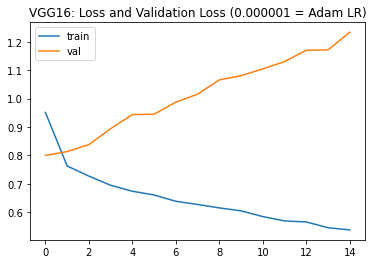

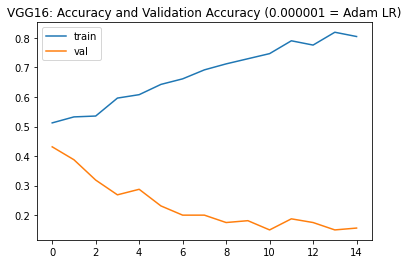

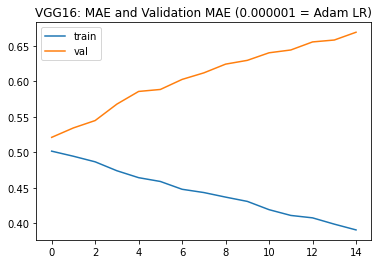

In [13]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.title('VGG16: Loss and Validation Loss (0.000001 = Adam LR)')
plt.legend();
plt.show()

plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='val')
plt.title('VGG16: Accuracy and Validation Accuracy (0.000001 = Adam LR)')
plt.legend();
plt.show()

plt.plot(hist.history['mae'], label='train')
plt.plot(hist.history['val_mae'], label='val')
plt.title('VGG16: MAE and Validation MAE (0.000001 = Adam LR)')
plt.legend();
plt.show()

In [14]:
hist.history['val_accuracy']
max_acc = max(hist.history['val_accuracy'])
min_acc = min(hist.history['val_accuracy'])
saved_accuracy = max_acc if (1-min_acc)<max_acc else min_acc
saved_accuracy

0.15000000596046448

In [15]:
model.save(f'/content/drive/MyDrive/CPSC 291 team dino/Model/save{saved_accuracy}acc')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/CPSC 291 team dino/Model/save0.15000000596046448acc/assets
